<a href="https://colab.research.google.com/github/ai-loli/MOVIE-RECOMMENDATION-SYSTEM/blob/main/Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle

In [ ]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2021-06-30 11:02:55--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  50.8MB/s    in 4.1s    

2021-06-30 11:02:59 (46.4 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [ ]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [ ]:
!ls

ml-20m	ml-20m.zip  sample_data


In [ ]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [ ]:
df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [ ]:
df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [ ]:
# Get user IDs, movie IDs, and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values - 2.5

In [ ]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimension
D = 10

In [ ]:
# Make a neural network
class Model(nn.Module):
  def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):
    super(Model, self).__init__()
    self.N = n_users
    self.M = n_items
    self.D = embed_dim

    self.u_emb = nn.Embedding(self.N, self.D)
    self.m_emb = nn.Embedding(self.M, self.D)
    self.fc1 = nn.Linear(2 * self.D, n_hidden)
    self.fc2 = nn.Linear(n_hidden, 1)

    # set the weights since N(0, 1) leads to poor results
    self.u_emb.weight.data = nn.Parameter(
        torch.Tensor(np.random.randn(self.N, self.D) * 0.01))
    self.m_emb.weight.data = nn.Parameter(
        torch.Tensor(np.random.randn(self.M, self.D) * 0.01))
  
  def forward(self, u, m):
    # pass u and m into their respective embeddings
    u = self.u_emb(u) # output is (num_samples, D)
    m = self.m_emb(m) # output is (num_samples, D)

    # merge or concatenate these 2 matrices together along axis = 1
    out = torch.cat((u, m), 1) # output is (num_samples, 2D)

    # then pass it to the ANN layers
    out = self.fc1(out)
    out = F.relu(out)
    out = self.fc2(out)
    return out

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


In [ ]:
model = Model(N, M, D)
model.to(device)

Model(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
criterion = nn.MSELoss() # loss(x,y) = (x-y)2
optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9) # momentum is a simple technique that improves both training speed and accuracy

In [ ]:
#function to train
def batch_gd2(model, criterion, optimizer, train_data, test_data, epochs, bs=512):
  train_users, train_movies, train_ratings = train_data
  test_users, test_movies, test_ratings = test_data

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  # batches per epoch
  Ntrain = len(train_users)
  batches_per_epoch = int(np.ceil(Ntrain / bs))

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []

    # shuffle each batch
    # by shuffling the data, we ensure that each data point creates an "independent" change on the model without being biased by the same points before them
    train_users, train_movies, train_ratings = shuffle(
        train_users, train_movies, train_ratings
    )

    for j in range(batches_per_epoch):
      # get the batch
      # The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.
      # Think of a batch as a for-loop iterating over one or more samples and making predictions
      # At the end of the batch, the predictions are compared to the expected output variables and an error is calculated
      # Stochastic Gradient Descent. Batch Size = 1
      users = train_users[j*bs:(j+1)*bs]
      movies = train_movies[j*bs:(j+1)*bs]
      targets = train_ratings[j*bs:(j+1)*bs]

      # conver to tensor
      users = torch.from_numpy(users).long()
      movies = torch.from_numpy(movies).long()
      targets = torch.from_numpy(targets)
    
      # reshape targets
      # Example: x.view(-1,1) this will output tensor shape [anything, 1] depending on the number of elements in x
      targets = targets.view(-1, 1).float()

      # move data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)

      # zero the parameter gradients
      # this is to ensure that we are not tracking any unnecessary information when we train our neural network
      # zero out the gradients so that you do the parameter update correctly
      optimizer.zero_grad()

      # Forward pass
      outputs = model(users, movies)
      loss = criterion(outputs, targets)  #Given an input and a target, compute the loss function associated to the criterion and return the result
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      # at the end when we get the losses we append to our list of losses for this epoch
      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) 
    
    test_loss = []
    for j in range(int(np.ceil(len(test_users) / bs))):
      # get the batch
      users = test_users[j*bs:(j+1)*bs]
      movies = test_movies[j*bs:(j+1)*bs]
      targets = test_ratings[j*bs:(j+1)*bs]

      # conver to tensor
      users = torch.from_numpy(users).long()
      movies = torch.from_numpy(movies).long()
      targets = torch.from_numpy(targets)
    
      # reshape targets
      # Example: x.view(-1,1) this will output tensor shape [anything, 1] depending on the number of elements in x
      targets = targets.view(-1, 1).float()

      # move data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)

      outputs = model(users, movies)
      loss = criterion(outputs, targets).item()
      test_loss.append(loss)
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [ ]:
# shuffle the data in corresponding order
# by shuffling the data, we ensure that each data point creates an "independent" change on the model without being biased by the same points before them
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

In [ ]:
Ntrain = int(0.8 * len(ratings))
train_users = user_ids[:Ntrain]
train_movies = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_users = user_ids[Ntrain:]
test_movies = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

train_losses, test_losses = batch_gd2(
    model,
    criterion,
    optimizer,
    (train_users, train_movies, train_ratings),
    (test_users, test_movies, test_ratings),
    10)

Epoch 1/10, Train Loss: 0.7359, Test Loss: 0.6909, Duration: 0:00:45.205658
Epoch 2/10, Train Loss: 0.6693, Test Loss: 0.6700, Duration: 0:00:44.559482
Epoch 3/10, Train Loss: 0.6367, Test Loss: 0.6497, Duration: 0:00:44.485410
Epoch 4/10, Train Loss: 0.6146, Test Loss: 0.6392, Duration: 0:00:44.396851
Epoch 5/10, Train Loss: 0.5985, Test Loss: 0.6366, Duration: 0:00:44.387523
Epoch 6/10, Train Loss: 0.5867, Test Loss: 0.6331, Duration: 0:00:44.372484
Epoch 7/10, Train Loss: 0.5776, Test Loss: 0.6316, Duration: 0:00:44.237049
Epoch 8/10, Train Loss: 0.5706, Test Loss: 0.6355, Duration: 0:00:44.325136
Epoch 9/10, Train Loss: 0.5649, Test Loss: 0.6287, Duration: 0:00:44.235639
Epoch 10/10, Train Loss: 0.5604, Test Loss: 0.6324, Duration: 0:00:44.302390


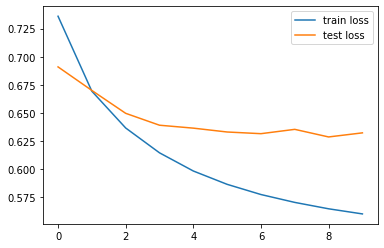

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend() # A legend is an area describing the elements of the graph
plt.show()

In [ ]:
# Suppose I want to find recommendations for user_id = 1
# First find all the movie_ids for movies they haven't yet watched
watched_movie_ids = df[df.new_user_id == 1].new_movie_id.values

In [ ]:
# movies rated by user 1
watched_movie_ids

array([   2,   61,   69,  108,  239,  257,  263,  465,  476,  537,  583,
        874,  891,  907, 1098, 1171, 1184, 1188, 1221, 1231, 1242, 1298,
       1326, 1494, 1528, 1616, 1684, 1881, 1885, 1886, 1887, 1888, 1889,
       1890, 1902, 2206, 2369, 2370, 2705, 2772, 2862, 2865, 3063, 3072,
       3086, 3361, 3423, 3443, 3464, 3474, 3612, 3662, 3824, 3825, 3830,
       3833, 3834, 3835, 3837, 3843, 3865], dtype=int16)

In [ ]:
# movies whuch user 1 has not rated
potential_movie_ids = df[~df.new_movie_id.isin(watched_movie_ids)].new_movie_id.unique()

In [ ]:
# How many user 1 has not rated?
potential_movie_ids.shape

(26683,)

In [ ]:
len(set(potential_movie_ids))

26683

In [ ]:
# Repeat the user id this many times
user_id_to_recommend = np.ones_like(potential_movie_ids)

In [ ]:
# Convert to torch tensor
t_user_ids = torch.from_numpy(user_id_to_recommend).long().to(device)
t_movie_ids = torch.from_numpy(potential_movie_ids).long().to(device)

# Get predictions
with torch.no_grad():
  predictions = model(t_user_ids, t_movie_ids)

In [ ]:
# Convert predictions to Numpy
# flatten to get 1D array instead of 2d array
predictions_np = predictions.cpu().numpy().flatten()

# Get sort index for predictions
sort_idx = np.argsort(-predictions_np)

In [ ]:
predictions_np

array([1.8155775 , 0.28463024, 1.8474042 , ..., 1.284921  , 1.2947899 ,
       1.26265   ], dtype=float32)

In [ ]:
sort_idx

array([ 176,   34,   26, ...,  964, 3305, 8583])

In [ ]:
# Top 10 predictions
top_10_movie_ids = potential_movie_ids[sort_idx[:10]]
top_10_scores = predictions_np[sort_idx[:10]]

for movie, score in zip(top_10_movie_ids, top_10_scores):
  print("movie:", movie, "score:", score)

movie: 453 score: 2.833981
movie: 1212 score: 2.8298604
movie: 1173 score: 2.8157215
movie: 1661 score: 2.732621
movie: 1075 score: 2.725697
movie: 1557 score: 2.7096786
movie: 1263 score: 2.6888444
movie: 1356 score: 2.6867056
movie: 1870 score: 2.6639597
movie: 148 score: 2.662428
